# Plot Melt Onset

A notebook to demonstrate plotting melt onset data.  I have tried to use standard packages.  The only possible exception is `xarray`.  I consider this a standard package and indispensible but others may not.

The melt onset data are on the NSIDC North Polar Stereographic grid: a 448 rows by 304 columns grid.  Melt onset grids are produced by NASA Goddard Space Flight Center, Maryland.  The production system is Unix with a Big Endian architecture.  Data are written to a flat binary grid.  If you are using a PC then these data will have to be byte swapped.  The mean onset date grid is already Little Endian.

In [2]:
import os
import datetime as dt

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import cartopy.crs as ccrs

import xarray as xr

Data are stored in the data directory of the Examples repo.

In [3]:
DATAPATH = '/home/apbarret/src/Examples/data'
onset2020_filepath = os.path.join(DATAPATH, '2020melt.int.304.448.new')
onsetMean_filepath = os.path.join(DATAPATH, 'ave_melt_1981_2010')

valid_ice_file = '/home/apbarret/src/nsidc-seaice/data/nsidc0622_valid_seaice_masks/NIC_valid_ice_mask.N25km.01.1972-2007.nc'  # From nsidc-seaice package

`read_meltonset` reads the data into the 448 x 304 grid.  The original onset data are 2-byte integers.  This is the default data-type.  However, mean onset grids are 4-byte floats. 

In [4]:
def read_meltonset(filepath, dtype='int16'):
    """Reads melt onset data on North Polar Stereographic grid"""
    rows = 448
    cols = 304
    return np.fromfile(filepath, dtype=dtype).reshape(rows, cols)

__Load the data, mask out invalid values and calculate anomalies__.  I use the NIC valid ice mask used in the NSIDC sea ice processing pipline to mask out spurious sea ice cells.  This mask is stored as netcdf.  I use `xarray` to read the file. 

In [5]:
onset2020 = read_meltonset(onset2020_filepath, dtype='int16').byteswap()  # Data is Big-Endian so bytes need to be swapped
onsetMean = read_meltonset(onsetMean_filepath, dtype='float32')

valid_ice = xr.open_dataset(valid_ice_file)['valid_ice_flag']  # Load NIC valid ice mask

# Mask data to show only values greater than 1 and where ice is expected
onset2020 = np.where((onset2020 >= 1) & (valid_ice == 1), onset2020, np.nan)
onsetMean = np.where((onsetMean >= 1) & (valid_ice == 1), onsetMean, np.nan)

anom2020 = onset2020 - onsetMean  # Calculate so that earlier melt onset is negative

I plot the data on the NSIDC North Polar Stereographic grid.  This is different from many "standard" North Polar Stereographic grids in two ways: the datum is the Hughs Ellipsoid, not WGS84, and the latitude of _true scale_ is 70 N, not 90 N.  This later difference is to reduce distortion at lower latitudes.  __Note that Polar Stereographic projections are *not* equal area!__  

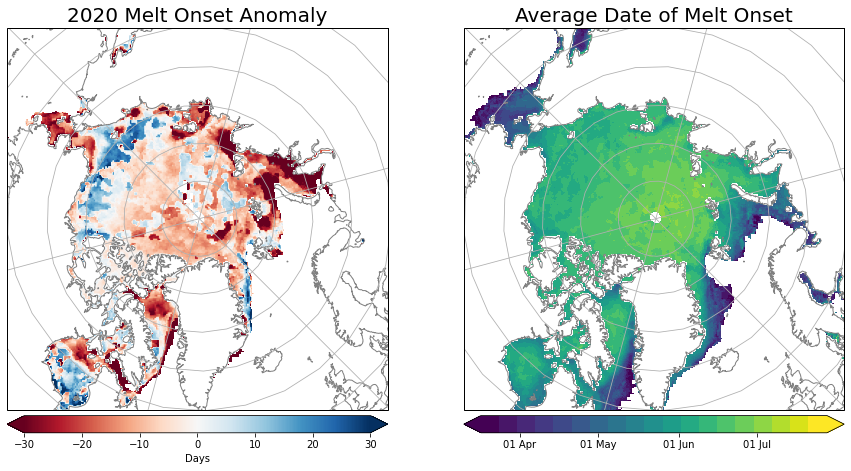

In [163]:
# Define projection info
src_proj = {'pixel_width': 25000,
            'pixel_height': 25000,
            'ccrs': {'central_latitude': 90.0,
                     'central_longitude': -45.0,
                     'false_easting': 0.0,
                     'false_northing': 0.0,
                     'true_scale_latitude': 70 },
            'bounds': [-3850000.000, 3750000., -5350000., 5850000.000]}
src_globe = ccrs.Globe(datum=None, semimajor_axis=6378273., semiminor_axis=6356889.449)
src_crs = ccrs.Stereographic(**src_proj['ccrs'], globe=src_globe)

fig = plt.figure(figsize=(15,10), constrained_layout=False)

# Plot 2020 melt onset as anomaly
ax1 = fig.add_subplot(121, projection=src_crs)
ax1.set_extent([0., 359., 60., 90], ccrs.PlateCarree())
ax1.coastlines('50m', color='0.5')
ax1.gridlines()
img1 = ax1.imshow(anom2020, vmin=-30, vmax=30, 
                  extent=src_proj['bounds'], origin='upper', transform=src_crs, cmap='RdBu')
ax1.set_title('2020 Melt Onset Anomaly', fontsize=20)
# Add colorbar
cax1 = fig.colorbar(img1, ax=ax1, orientation='horizontal', extend='both', label='Days', pad=0.01)

# Plot Mean melt onset dates
# - Set colorbar ticks
doybeg = 80
doyend = 210
dates = [dt.datetime(2020, m, 1) for m in range(1,13)]
ticks = [d.timetuple().tm_yday for d in dates if (d.timetuple().tm_yday >= doybeg) | (d.timetuple().tm_yday >= doyend)]
ticknames = [d.strftime('%d %b') for d in dates if (d.timetuple().tm_yday >= doybeg) | (d.timetuple().tm_yday >= doyend)]
# - Set norm for co
bounds = np.arange((doybeg // 7) * 7, ((doyend // 7) + 1) * 7, 7)
norm = mcolors.BoundaryNorm(bounds, ncolors=256)

ax2 = fig.add_subplot(122, projection=src_crs)
ax2.set_extent([0., 359., 60., 90], ccrs.PlateCarree())
ax2.coastlines('50m', color='0.5')
ax2.gridlines()
img2 = ax2.imshow(onsetMean, norm=norm, extent=src_proj['bounds'], origin='upper', transform=src_crs)
ax2.set_title('Average Date of Melt Onset', fontsize=20)
# Add colorbar
cax2 = fig.colorbar(img2, ax=ax2, orientation='horizontal', extend='both', pad=0.01);
cax2.set_ticks(ticks)
cax2.set_ticklabels(ticknames)

fig.savefig('2020_melt_onset_anom_and_mean.png')